# Classifying Gcn4 ADs into categories from [TADA Paper](https://www.nature.com/articles/s41586-024-07707-3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from TADA_T2.TADA import predict, predict_from_fasta


In [100]:
# Read in Gcn4 data
fn = "../adhunter/data/OrthologTilingDFwActivities_20220131.csv"
gcn4_df = pd.read_csv(fn)
gcn4_df = gcn4_df.loc[gcn4_df.Activity != 0.0]
gcn4_df = gcn4_df.iloc[:, 1:]
gcn4_df = gcn4_df.loc[gcn4_df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]


seqs = gcn4_df.Seq.to_numpy()
activity = gcn4_df.Activity.to_numpy()
thresh = 80_000
# # get binary labels based on threshold
# y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)
# # scale data to have mean 0 and variance 1
# y_cont = activity.reshape(-1, 1)
# scaler = preprocessing.StandardScaler().fit(y_cont)
# y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

df_ad = gcn4_df.loc[gcn4_df["Activity"] >= thresh].copy()

In [71]:
# padi_df = pd.read_csv("../adhunter/data/MorffyADScoresFeaturesSequences.csv").rename(columns={"ADseq" : "seq"})
# # padi_new = pd.read_csv("../adhunter/data/Morffy_ARF_NEWADSCORE.CSV").rename(columns={"NAME": "Name"})
# # padi_df = pd.merge(padi_df, padi_new, on="Name")
# # Some seqs aren't 40AA
padi_df = pd.read_csv("../data/tsne-clustering_6clusters.csv")
padi_df = padi_df[padi_df["sequence"].str.len() == 40]
padi_df

,Unnamed: 0,tsne-1,tsne-2,label,idx,name,scale_score,sequence
0,0,38.848900,22.861152,1,94,ARF17_11-50,2.220723,PFPPAKRLKYPQPGGGFLSGDDGEILYPQSGLSSAAAPDP
1,1,4.418734,-10.805563,5,105,ARF17_51-90,1.229074,SPSMFSYSTFPAGMQGARQYDFGSFNPTGFIGGNPPQLFT
2,2,2.802221,-9.678310,5,106,ARF17_61-100,1.949662,PAGMQGARQYDFGSFNPTGFIGGNPPQLFTNNFLSPLPDL
3,3,-10.171829,-36.767071,4,123,ARF19_11-50,2.844980,PPFFRPKYPRQPGMPDDELDMENAFKRAMPWMGEDFGMKD
4,4,28.967302,22.871886,1,133,ARF19_201-240,1.352127,SQLQQQSMLPTGAKMTHQNINSMGNKGLSQMTSFAQEMQF
...,...,...,...,...,...,...,...,...
6380,6380,-5.237754,-32.107007,4,70748,AT5G67180.1_261,1.682533,RNGHNLGLSLGESSSEEFRLKSDIASIRSRIRDEERLLGS
6381,6381,-16.172177,28.905072,0,70813,AT5G67411.1_141,1.859266,NFISRLRSLYNYMWIPYDTAEMFLTRGSEQRQWYEADISW
6382,6382,-35.776633,11.714982,3,70814,AT5G67411.1_151,2.150537,NYMWIPYDTAEMFLTRGSEQRQWYEADISWKIDNVVAKEG
6383,6383,-17.815534,-43.577998,4,70837,AT5G67420.1_201,1.961084,TPSSTRRRSVTPSMNSEDSGTTTTTTAFCDKGDVYGNGGG


In [73]:
# from TADA_T2.backend.features import create_features
# features = create_features(seqs)
from localcider.sequenceParameters import SequenceParameters
import alphaPredict as alpha


def get_feats(sequence, SEQUENCE_WINDOW = 5, STEPS = 1, LENGTH = 40, PROPERTIES = 42):
    aliphatics_set = set(['I', 'V', 'L', 'A'])
    aromatics_set = set(['W', 'F', 'Y'])
    branching_set = set(['V', 'I', 'T'])
    charged_set = set(['K', 'R', 'H', 'D', 'E'])
    negatives_set = set(['D', 'E'])
    phosphorylatables_set = set(['S', 'T', 'Y'])
    polars_set = set(['R', 'K', 'D', 'E', 'Q', 'N', 'Y'])
    hydrophobics_set = set(['W', 'F', 'L', 'V', 'I', 'C', 'M'])
    positives_set = set(['K', 'R', 'H'])
    sulfurcontaining_set = set(['M', 'C'])
    tinys_set = set(['G', 'A', 'S', 'P'])
    amino_acids = ['R', 'K', 'D', 'E', 'Q', 'N', 'H', 'S', 'T', 'Y', 'C', 'W', 'M', 'A', 'I', 'L', 'F', 'V', 'P', 'G']

    SEQUENCE_LENGTH = len(sequence)
    SeqOb = SequenceParameters(sequence)
    kappa = np.full(int((SEQUENCE_LENGTH-SEQUENCE_WINDOW)/STEPS+1), SeqOb.get_kappa())
    omega = np.full(int((SEQUENCE_LENGTH-SEQUENCE_WINDOW)/STEPS+1), SeqOb.get_Omega())

    # make subseqs.
    sub_seq = [sequence[STEPS * j:STEPS * j + SEQUENCE_WINDOW] for j in range((SEQUENCE_LENGTH - SEQUENCE_WINDOW) // STEPS + 1)]
    one = np.array([sum(aa in aliphatics_set for aa in seq) for seq in sub_seq])
    two = np.array([sum(aa in aromatics_set for aa in seq) for seq in sub_seq])
    three = np.array([sum(aa in branching_set for aa in seq) for seq in sub_seq])
    four = np.array([sum(aa in charged_set for aa in seq) for seq in sub_seq])
    five = np.array([sum(aa in negatives_set for aa in seq) for seq in sub_seq])
    six = np.array([sum(aa in phosphorylatables_set for aa in seq) for seq in sub_seq])
    seven = np.array([sum(aa in polars_set for aa in seq) for seq in sub_seq])
    eight = np.array([sum(aa in hydrophobics_set for aa in seq) for seq in sub_seq])
    nine = np.array([sum(aa in positives_set for aa in seq) for seq in sub_seq])
    ten = np.array([sum(aa in sulfurcontaining_set for aa in seq) for seq in sub_seq])
    eleven = np.array([sum(aa in tinys_set for aa in seq) for seq in sub_seq])
    sstructure = np.array([sum(alpha.predict(seq)) / len(seq) for seq in sub_seq])
    count_20 = np.array([[s.count(aa) for s in sub_seq] for aa in amino_acids])

    # turn subseqs into SeqObs.
    sub_seq = [SequenceParameters(seq) for seq in sub_seq]
    hydropathy = np.array([seq.get_mean_hydropathy() for seq in sub_seq])
    hydropathy_ww = np.array([seq.get_WW_hydropathy() for seq in sub_seq])
    ncpr = np.array([seq.get_NCPR() for seq in sub_seq])
    promoting = np.array([seq.get_fraction_disorder_promoting() for seq in sub_seq])
    fcr = np.array([seq.get_FCR() for seq in sub_seq])
    charge = np.array([seq.get_mean_net_charge() for seq in sub_seq])
    negative = np.array([seq.get_fraction_negative() for seq in sub_seq])
    positive = np.array([seq.get_fraction_positive() for seq in sub_seq])

    # make array of features.
    x = np.array([kappa, omega, hydropathy, hydropathy_ww, ncpr, promoting, fcr, charge, negative, positive,
                    one, two, three, four, five, six, seven, eight, nine, ten, eleven, sstructure])
    # concatenate x and count_20
    x = np.concatenate([x, count_20])
    # do padding 
    padded_x = np.zeros((PROPERTIES, (LENGTH - SEQUENCE_WINDOW) // STEPS + 1))
    padded_x[:x.shape[0], :x.shape[1]] = x
    return padded_x

features_gcn4 = df_ad["Seq"].apply(get_feats, SEQUENCE_WINDOW=40).values

In [74]:
features_padi = padi_df["sequence"].apply(get_feats, SEQUENCE_WINDOW=40).values

In [103]:
# features_gcn4 = np.hstack(features_gcn4)
# features_padi = np.hstack(features_padi)
features = np.hstack([np.hstack(features_gcn4), np.hstack(features_padi)]).transpose()
df = pd.concat(
    [df_ad["Seq"], padi_df["sequence"]], 
    keys=['gcn4', 'padi']).reset_index().drop('level_1', axis=1)
df.columns = ['dataset', 'seq']
df

,dataset,seq
0,gcn4,RYTFRSNARAASGQANANYQAFTAGSALNGPSLPAPSLFA
1,gcn4,AHSDHSAQRGIRLSGLEAREGTEHPQAHLSPASSRIEVAS
2,gcn4,LEAREGTEHPQAHLSPASSRIEVASWAHEFQRLAPNIAAT
3,gcn4,GTEHPQAHLSPASSRIEVASWAHEFQRLAPNIAATGPAIA
4,gcn4,PQQTWASYNPVVSNNASASEVRGVPAPEDDFDDAMNLWMG
...,...,...
10524,padi,RNGHNLGLSLGESSSEEFRLKSDIASIRSRIRDEERLLGS
10525,padi,NFISRLRSLYNYMWIPYDTAEMFLTRGSEQRQWYEADISW
10526,padi,NYMWIPYDTAEMFLTRGSEQRQWYEADISWKIDNVVAKEG
10527,padi,TPSSTRRRSVTPSMNSEDSGTTTTTTAFCDKGDVYGNGGG


In [104]:
# feat_mtx = np.hstack(features).transpose()

In [105]:
from sklearn.cluster import KMeans

# features_flattened = features.flatten()#features.reshape(features.shape[0], -1)
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(features)

In [106]:
df["kmeans"] = kmeans.labels_

In [135]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

pca = PCA(n_components=10)
X_pca = pca.fit_transform(features)
fit = UMAP(n_neighbors=15,)
X_umap = fit.fit_transform(X_pca)
# X_umap = fit.fit_transform(feat_mtx)

/opt/homebrew/Caskroom/miniconda/base/envs/tada/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


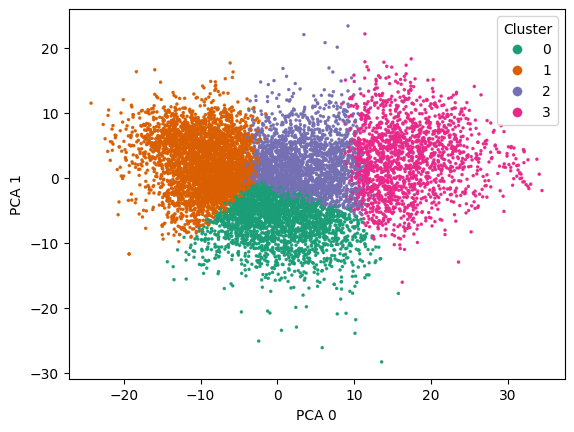

In [136]:
pca0, pca1 = PCA(n_components=2).fit_transform(features).transpose()
df["PCA 0"] = pca0
df["PCA 1"] = pca1
sns.scatterplot(df,
                x='PCA 0', y='PCA 1', hue='kmeans',
                edgecolor=None, s=5, palette="Dark2")
plt.legend(markerscale=3, title="Cluster")
plt.show()
# sns.scatterplot(df,
#                 x='PCA 0', y='PCA 1', hue='dataset',
#                 edgecolor=None, s=5, palette="Dark2")
# plt.legend(markerscale=3, title="Cluster")
# plt.show()

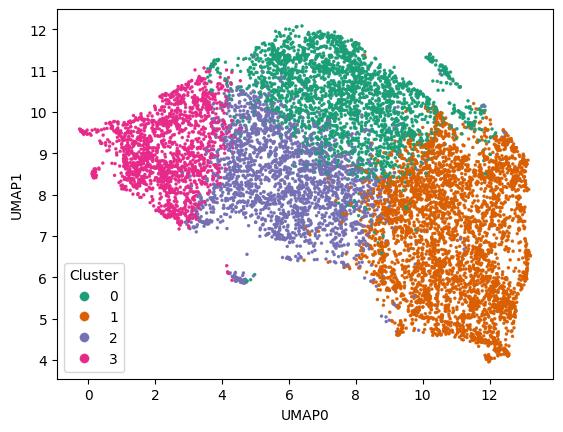

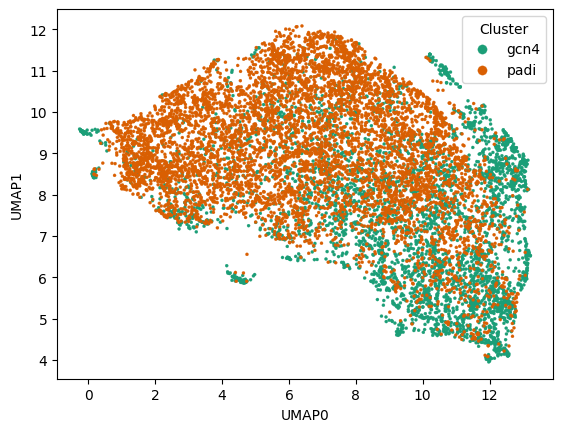

In [137]:
x, y = X_umap.transpose()
# df.loc[:, ["x_umap", "y_umap"]] = (x, y)
df["UMAP0"] = x
df["UMAP1"] = y
sns.scatterplot(df,
                x='UMAP0', y='UMAP1', hue='kmeans',
                edgecolor=None, s=5, palette="Dark2")
plt.legend(markerscale=3, title="Cluster")
plt.show()
sns.scatterplot(df,
                x='UMAP0', y='UMAP1', hue='dataset',
                edgecolor=None, s=5, palette="Dark2")
plt.legend(markerscale=3, title="Cluster")
plt.show()

In [143]:
X_tsne = TSNE(n_jobs=-1).fit_transform(X_pca)

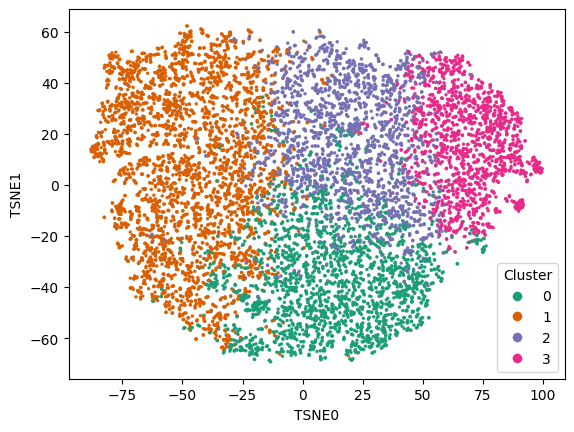

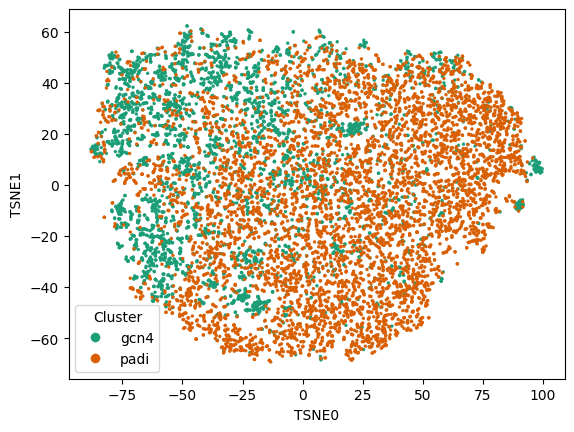

In [144]:
x_tsne, y_tsne = X_tsne.transpose()
# df.loc[:, ["X_tsne", "y_TSNE"]] = (x, y)
df["TSNE0"] = x_tsne
df["TSNE1"] = y_tsne
sns.scatterplot(df,
                x='TSNE0', y='TSNE1', hue='kmeans',
                edgecolor=None, s=5, palette="Dark2")
plt.legend(markerscale=3, title="Cluster")
plt.show()
sns.scatterplot(df,
                x='TSNE0', y='TSNE1', hue='dataset',
                edgecolor=None, s=5, palette="Dark2")
plt.legend(markerscale=3, title="Cluster")
plt.show()

## Read in PADI's tSNE clusters + seqs

In [8]:
padi = pd.read_csv("../data/tsne-clustering_6clusters.csv")
padi_seqs = padi["sequence"]
padi_features = create_features(padi_seqs)

In [9]:
pd.concat([padi, df])

,Unnamed: 0,tsne-1,tsne-2,label,idx,name,scale_score,sequence,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,kmeans,x_umap,y_umap
0,0.0,38.848900,22.861152,1.0,94.0,ARF17_11-50,2.220723,PFPPAKRLKYPQPGGGFLSGDDGEILYPQSGLSSAAAPDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,4.418734,-10.805563,5.0,105.0,ARF17_51-90,1.229074,SPSMFSYSTFPAGMQGARQYDFGSFNPTGFIGGNPPQLFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.802221,-9.678310,5.0,106.0,ARF17_61-100,1.949662,PAGMQGARQYDFGSFNPTGFIGGNPPQLFTNNFLSPLPDL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,-10.171829,-36.767071,4.0,123.0,ARF19_11-50,2.844980,PPFFRPKYPRQPGMPDDELDMENAFKRAMPWMGEDFGMKD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,28.967302,22.871886,1.0,133.0,ARF19_201-240,1.352127,SQLQQQSMLPTGAKMTHQNINSMGNKGLSQMTSFAQEMQF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,210.0,86.0,DPADPVAVKRARNTMAARKSRRRKLEKQEQMEDRIRELEA,24922.132950,4.0,-4.314923,-1.794482
88363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,215.0,91.0,VAVKRARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKS,16670.336716,4.0,6.547352,0.814372
88364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,220.0,96.0,ARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQ,8059.752238,4.0,4.891986,0.459774
88365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,225.0,101.0,AARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAM,53558.456206,4.0,5.669097,0.300073


In [10]:
padi_features_flattened = padi_features.reshape(padi_features.shape[0], -1)
all_feats = np.concatenate([features_flattened, padi_features_flattened])
kmeans_both = KMeans(n_clusters=6, random_state=0, n_init=10).fit(all_feats)

In [11]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(all_feats)
fit = umap.UMAP()
# X_umap = fit.fit_transform(X_pca)
X_umap = fit.fit_transform(all_feats)
x, y = X_umap.transpose()
# X_umap = fit.fit_transform(features_flattened)

/opt/homebrew/Caskroom/miniconda/base/envs/tada/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [12]:
f2 = TSNE(perplexity=X_pca.shape[0] // 100, metric="cosine")
X_tsne = f2.fit_transform(X_pca)
xt, yt = X_tsne.transpose()

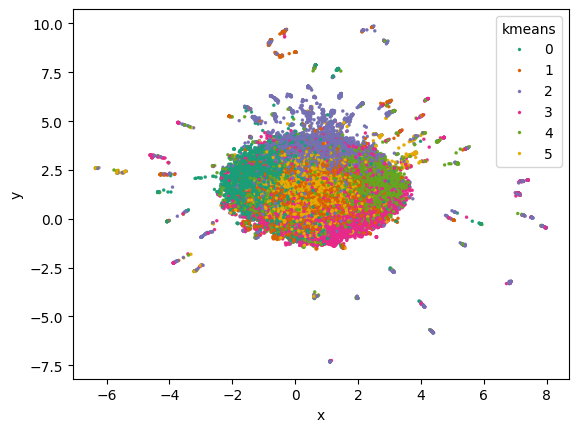

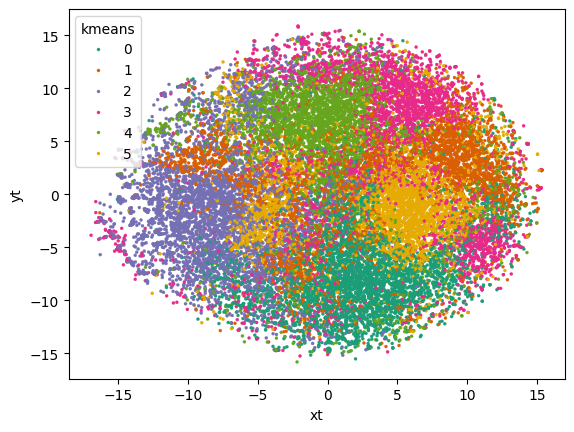

In [13]:
res = pd.DataFrame({
    "x": x,
    "y": y,
    "xt": xt,
    "yt": yt,
    "kmeans": kmeans_both.labels_,})

sns.scatterplot(res, x='x', y='y', hue='kmeans', edgecolor=None, s=5, palette="Dark2")
plt.show()
sns.scatterplot(res, x='xt', y='yt', hue='kmeans', edgecolor=None, s=5, palette="Dark2")
plt.show()